# Boiler plate code for loading the data

This code is from Anu's code at https://github.com/mrvollger/m6A-calling/blob/main/m6a_calling/m6a_calling.py 

This new data set is gotten from ~anupamaj/m6A_train_more_norm.npz 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import pickle

class DataGenerator(torch.utils.data.Dataset):
    """
    Data generator for the m6A model. It randomly selects
    batches from the data to train the m6A model.
    """
    def __init__(self, features, labels, random_state=None):
        """
        Constructor for the data generator class, expects features
        and labels matrices.
        :param features: numpy.array, Nx15, N=number of sequences,
                                      each sequence is of length 15.
        :param labels: numpy array, one hot encoded labels for whether
                                    a sequence in features variable contains
                                    methylated A or not.
        :param random_state: numpy.random_state, allow reproducibility by selecting
                                                 a seed for random operations beforehand.
        """
        self.random_state = random_state
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        """
        Get random indices from the training data
        to form batches.
        :param idx: numpy.array, indices to retrieve, ignoring for now.
        :return: x, y: features and labels from selected indices.
        """
        i = self.random_state.choice(len(self.features))

        x = self.features[i]
        y = self.labels[i]

        x = torch.tensor(x)
        y = torch.tensor(y)

        return x, y


def m6AGenerator(data_path, random_state=None, pin_memory=True,
                 num_workers=0, batch_size=32):
    """
    This generator returns a training data generator as well as
    validation features and labels
    :param data_path: str, path where the data matrix is stored.
    :param random_state: int, seed for numpy random_state.
    :param pin_memory: bool, Makes CUDA efficient by skipping one copy
                             operation, true by default.
    :param num_workers: int, number of worker threads the generator can
                             utilize, 0 by default.
    :param batch_size: int, number of examples in each batch
    :return: X_gen: training data generator, X_val: validation features, y_val: validation labels
    """
    # initialize Random state
    random_state = np.random.RandomState(random_state)

    # Load training and validation data
    train_val_data = np.load(data_path, allow_pickle=True)

    # Get the dictionary from the containing relevant data
    train_val_data = train_val_data['save_data_dict'][()]

    # Load training and validation features and labels
    X_train = train_val_data['X_train']
    y_train = train_val_data['y_train']
    X_val = train_val_data['X_val']
    y_val = train_val_data['y_val']

    print(f"Training features shape {X_train.shape}, training labels shape: {y_train.shape}")
    print(f"Validation features shape {X_val.shape}, validation labels shape: {y_val.shape}")

    # Get the training data generator
    X_gen = DataGenerator(X_train,
                          y_train,
                          random_state=random_state)

    # Wrap it in a data loader
    X_gen = torch.utils.data.DataLoader(X_gen,
                                        pin_memory=pin_memory,
                                        num_workers=num_workers,
                                        batch_size=batch_size)

    return X_gen, (X_val, y_val)

In [2]:
# Loading code from Anu
X_train, (X_val, y_val) = m6AGenerator("data/m6A_train_more_norm.npz", random_state=None, pin_memory=True, num_workers=2, batch_size=1000)

Training features shape (180503, 9, 15), training labels shape: (180503, 2)
Validation features shape (60168, 9, 15), validation labels shape: (60168, 2)


# Baseline analyses


### Exploratory plots
First we start by making histograms and scatter plots of the base data. In the histogram plot, we are checking how often the center position is A, C, G, or T. In the scatter plots, we are checking if there is any obvious baseline relationships between the variables and the methylation status (1 = methylated, 0 = unmethylated)

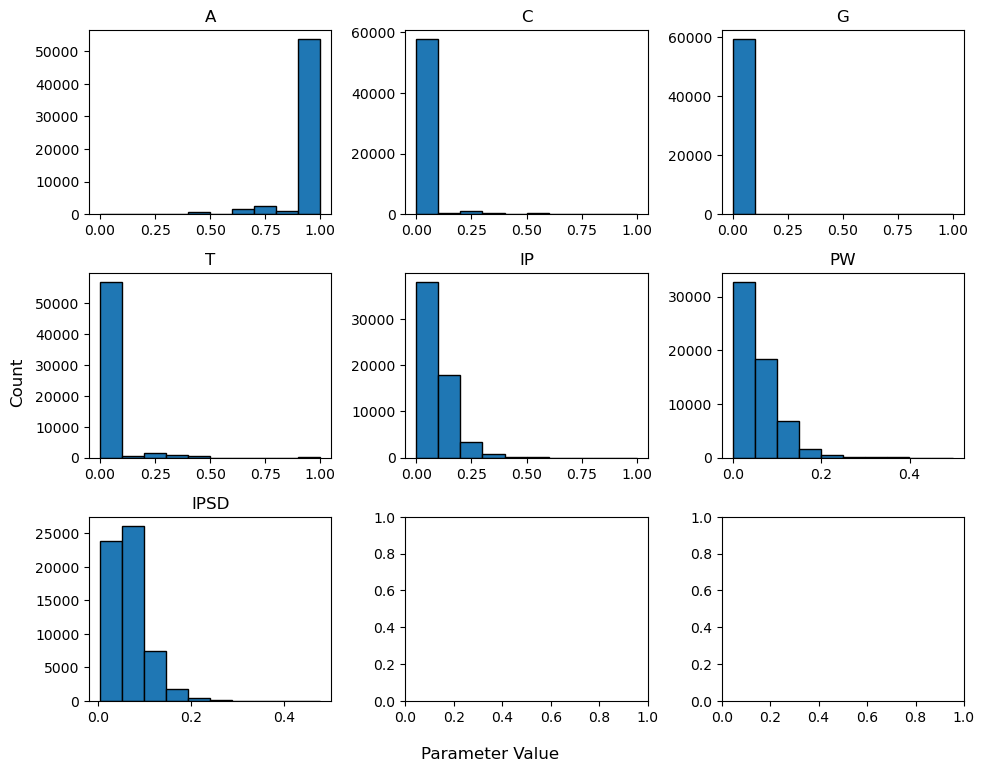

In [13]:
parameters = ['A', 'C', 'G', 'T', 'IP', 'PW', "IPSD"]
fig, axs = plt.subplots(3, 3, figsize=(10, 7.75))
for i in range(7):
    axs.flat[i].hist(X_val[:, i, 7], edgecolor="black")
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supylabel("Count")
fig.supxlabel("Parameter Value")
fig.tight_layout()

In [11]:
for i in range(4):
    print(f"Sum of positive {parameters[i]}: {sum(X_val[y_val[:, 0] == 1, i, 7])/sum(y_val[:, 0] == 1)}")

print("\n\n")
for i in range(4):
    print(f"Sum of negative {parameters[i]}: {sum(X_val[y_val[:, 0] != 1, i, 7])/sum(y_val[:, 0] != 1)}")

Sum of positive A: 0.9642873186052654
Sum of positive C: 0.013727848245987663
Sum of positive G: 0.004008580377220875
Sum of positive T: 0.01797625277155612



Sum of negative A: 0.9666188133895042
Sum of negative C: 0.011803190704552772
Sum of negative G: 0.0033833363788865842
Sum of negative T: 0.018194659527315204


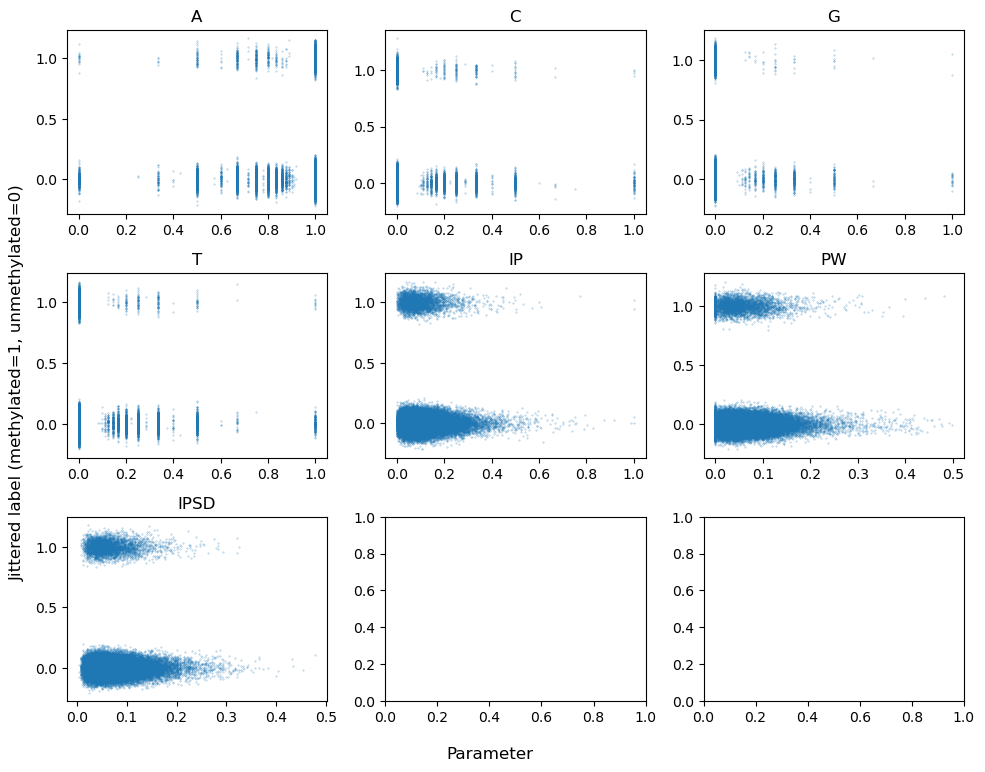

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(10, 7.75))
for i in range(7):
    axs.flat[i].scatter(X_val[:, i, 7], y_val[:, 0] + np.random.normal(loc=0, scale=.05, size=y_val[:, 0].shape), s=.1, alpha=.5)
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supxlabel("Parameter")
fig.supylabel("Jittered label (methylated=1, unmethylated=0)") 
fig.tight_layout()

### AUROC curves using the baseline values

Here we are averaging the values of each of the values across all of the subreads (done previously by Mitchell and Anu) and also averaging over the entire window of 7bp up and down the center value that we were interested in. We found that the base pairs themselves did not give too much information about whether there was methylation in the middle site or not, but found that the average of the IP and PW values did have some improvement over random guesses. We show ROC curves for each parameter and also provide an AUROC value. 

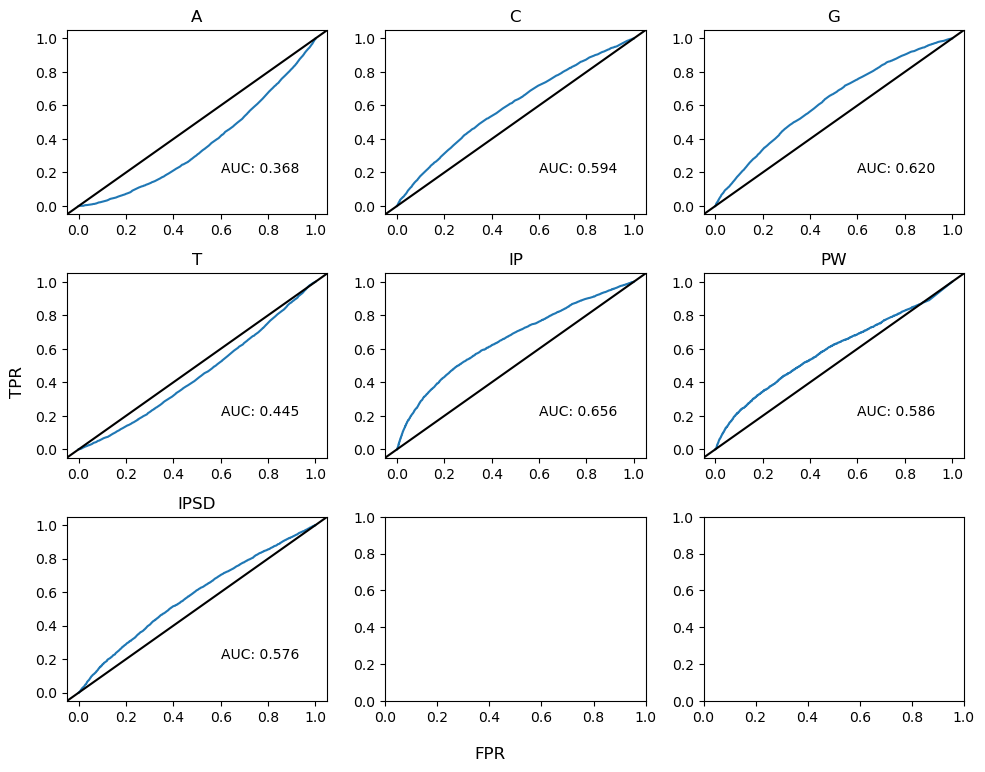

In [16]:
import sklearn.metrics

fig, axs = plt.subplots(3, 3, figsize=(10, 7.75))
for i in range(7):
    fpr, tpr, thresholds = metrics.roc_curve(y_val[:, 0], np.sum(X_val[:, i, :], axis=1), pos_label=1)
    axs.flat[i].plot(fpr, tpr)
    axs.flat[i].axline([0,0], slope=1, c="black")
    axs.flat[i].text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supxlabel("FPR")
fig.supylabel("TPR")
fig.tight_layout()



### Logistic Regression

We now use a logistic regression implemented in pytorch to establish a baseline model for the data. We then trained the model using the training data over 25 epochs, with each batch being 1000 observations. We show the ROC curves for the model, and also try do some interpretation of the model.

In [17]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [20]:
losses = []
losses_test = []
Iterations = []
epochs = 25
training_loss = []
learning_rate = 0.0001

# model = LogisticRegression(135, 1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    iteration = 0
    for batch in X_train:
        x = batch[0]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2]).float()
        labels = batch[1][:,0].float()
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x)
        loss = criterion(torch.squeeze(outputs), labels) 
        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        training_loss.append(loss.detach().numpy())
        iteration += 1
        if iteration % 10000 == 0 : print(iteration)
    y_pred = model(torch.tensor(X_val_flat).float()).detach().numpy()
    y_obs = y_val[:, 0]
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    print(f"AUC: {metrics.auc(fpr, tpr)}")
#     with torch.no_grad():
#         # Calculating the loss and accuracy for the test dataset
#         correct_test = 0
#         total_test = 0
#         outputs_test = torch.squeeze(model(X_test))
#         loss_test = criterion(outputs_test, y_test)

#         predicted_test = outputs_test.round().detach().numpy()
#         total_test += y_test.size(0)
#         correct_test += np.sum(predicted_test == y_test.detach().numpy())
#         accuracy_test = 100 * correct_test/total_test
#         losses_test.append(loss_test.item())

#         # Calculating the loss and accuracy for the train dataset
#         total = 0
#         correct = 0
#         total += y_train.size(0)
#         correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
#         accuracy = 100 * correct/total
#         losses.append(loss.item())
#         Iterations.append(iter)

#         print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
#         print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")


Epoch: 0
AUC: 0.6881779478787012
Epoch: 1
AUC: 0.7014320615051046
Epoch: 2
AUC: 0.7115102391414059
Epoch: 3
AUC: 0.7193754880834523
Epoch: 4
AUC: 0.725692088117365
Epoch: 5
AUC: 0.7308874582645787
Epoch: 6
AUC: 0.7352758414965018
Epoch: 7
AUC: 0.7390469742040257
Epoch: 8
AUC: 0.7423556915249564
Epoch: 9
AUC: 0.745293713201261
Epoch: 10
AUC: 0.7479524248632673
Epoch: 11
AUC: 0.7503684861180174
Epoch: 12
AUC: 0.7525803832121007
Epoch: 13
AUC: 0.7546202323220166
Epoch: 14
AUC: 0.7565182571378977
Epoch: 15
AUC: 0.7582844736926153
Epoch: 16
AUC: 0.7599467132418618
Epoch: 17
AUC: 0.7615100850110729
Epoch: 18
AUC: 0.7629740744195487
Epoch: 19
AUC: 0.7643538555010179
Epoch: 20
AUC: 0.7656681214358946
Epoch: 21
AUC: 0.7669038979619737
Epoch: 22
AUC: 0.7680716766724893
Epoch: 23
AUC: 0.7691798054808864
Epoch: 24
AUC: 0.7702290526000587


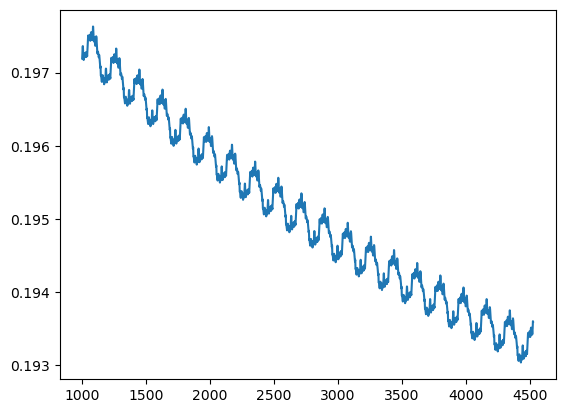

In [17]:
plt.plot(pd.Series(training_loss).rolling(1000).mean())

Text(0.6, 0.2, 'AUC: 0.791')

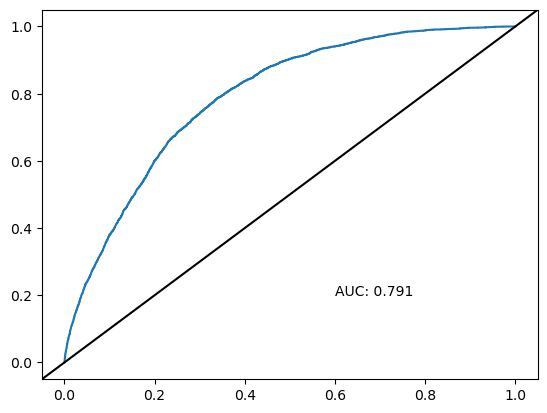

In [18]:
X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
y_pred = model(torch.tensor(X_val_flat).float()).detach().numpy()
y_obs = y_val[:, 0]
fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.axline([0,0], slope=1, c="black")
plt.text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 

In [18]:
pickle.dump(model, open("output_models/logistic_regression_m6A_train_more_norm.pickle", "wb"))
torch.save(model.state_dict(), "output_models/logistic_regression_m6A_train_more_norm_state_dict.torch")

In [19]:
labels = []
for base in ["A", "C", "G", "T", "IP", "PW", "Offset"]:
    for position in range(1, 16):
        labels.append(base + str(position))
print(labels)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'IP1', 'IP2', 'IP3', 'IP4', 'IP5', 'IP6', 'IP7', 'IP8', 'IP9', 'IP10', 'IP11', 'IP12', 'IP13', 'IP14', 'IP15', 'PW1', 'PW2', 'PW3', 'PW4', 'PW5', 'PW6', 'PW7', 'PW8', 'PW9', 'PW10', 'PW11', 'PW12', 'PW13', 'PW14', 'PW15', 'Offset1', 'Offset2', 'Offset3', 'Offset4', 'Offset5', 'Offset6', 'Offset7', 'Offset8', 'Offset9', 'Offset10', 'Offset11', 'Offset12', 'Offset13', 'Offset14', 'Offset15']


### Interpreting the logistic regression model

Below I'm printing the weights and the estimated parameters for the model. The first 60 values indicate the position and a one-hot encoding of whether that position is that weight. For example, if "A1" is 1, it means that there was an "A" at position 1. We then have the IP values for each position, the PW values for each position, and the offset values for each position. We found that generally that large values of IP tend to indicate that there is a positive methylation status at that position. 

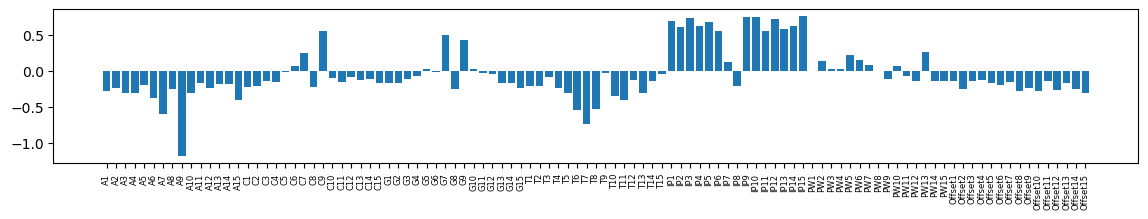

In [20]:
weights = model.linear.weight.detach().numpy().flatten()
plt.figure(figsize=[14, 2])
plt.bar(labels, weights)
_ = plt.xticks(rotation = 90, fontsize=6)

# Building a random forest (regressor)

In [22]:
x = np.load("data/m6A_train_more_norm.npz", allow_pickle=True)

# Load the data
X_train = x["save_data_dict"][()]['X_train']

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
# X_train = X_train[:1000]

# Load the labels
y_train = x["save_data_dict"][()]['y_train']

# Convert the labels to just 1 dimension
y_train = y_train[:, 0]
# y_train = y_train[:1000]

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, verbose=True, n_jobs=10)
# Train the model on training data
rf.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  9.1min finished


RandomForestRegressor(n_jobs=10, random_state=42, verbose=True)

In [23]:
import joblib 
pickle.dump(rf, open("output_models/random_forest_m6A_train_more_norm.pickle", "wb"))
joblib.dump(rf, "output_models/random_forest_m6A_train_more_norm.joblib")

['output_models/random_forest_m6a_train_new.joblib']

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished


Text(0.6, 0.2, 'AUC: 0.837')

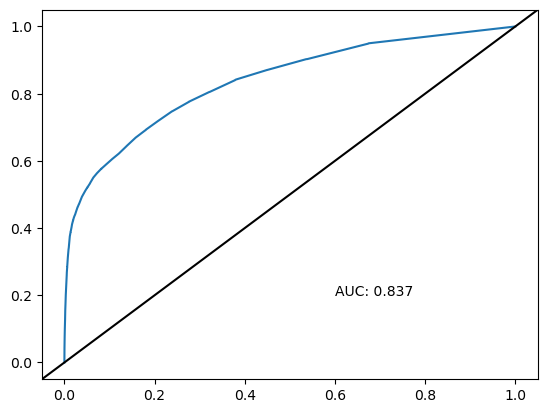

In [24]:
X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
y_pred = rf.predict(X_val_flat)
y_obs = y_val[:, 0]
fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.axline([0,0], slope=1, c="black")
plt.text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 

# Using XG-boost to classify (regressor)

In [25]:
from numpy import loadtxt
from xgboost import XGBRegressor

/net/noble/vol1/home/alantmin/miniconda3/envs/m6a-cpu/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
x = np.load("data/m6A_train_more_norm.npz", allow_pickle=True)

# Load the data
X_train = x["save_data_dict"][()]['X_train']

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

# Load the labels
y_train = x["save_data_dict"][()]['y_train']

# Convert the labels to just 1 dimension
y_train = y_train[:, 0]

# Load the Validation data
X_val = x["save_data_dict"][()]['X_val']
y_val = x["save_data_dict"][()]['y_val']


In [29]:
model = XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Text(0.6, 0.2, 'AUC: 0.865')

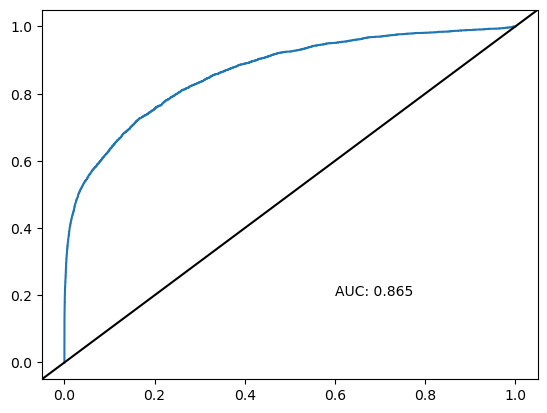

In [28]:
X_val = x["save_data_dict"][()]['X_val']
y_val = x["save_data_dict"][()]['y_val']
X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
y_pred = model.predict(X_val_flat)
y_obs = y_val[:, 0]

fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.axline([0,0], slope=1, c="black")
plt.text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 

In [28]:
pickle.dump(model, open("output_models/xgboost_m6a_calling_large.pickle", "wb"))

# Creating a transformer model